In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit

In [2]:
import numpy as np
import sys
sys.path.append('/Users/lkbayne/Desktop/python/tools')
import chem_calcs as cc

In [81]:
#importing my file as it comes out of the pFI program
file = 'Day_35.txt'

df = pd.read_csv(file, sep="\t", engine='python')

In [82]:
#filtering for only the sample name, and the needed absorbances
filtered_df = df[['Name', 'AVE810_1050', 'AVE880_1050']]

In [83]:
c1 = 4997.89 #PO4 concentration [uM]
v1 = 40 #spike [uL]
c2 = None
v2 = 50*1000 #250 mL bottle in uL
PO4_conc = cc.conc_to_dil(c1, v1, c2, v2)
print(PO4_conc)
c1 = 10255 #Si concentration [uM]
v1 = 220 #spike [uL]
c2 = None
v2 = 50*1000 #250 mL bottle in uL
Si_conc = cc.conc_to_dil(c1, v1, c2, v2)
print(Si_conc)

3.9983120000000003
45.122


In [84]:
#calibration curve dilution values
dil_0 = 0
dil_1 = (600-450)/600
dil_2 = (600-300)/600
dil_3 = (600-150)/600
dil_4 = (600-50)/600
Si_cali_concs = np.array([dil_0, dil_0, dil_0, dil_1, dil_1, dil_1, dil_2, dil_2, dil_2, dil_3, dil_3, dil_3, dil_4, dil_4, dil_4]) * Si_conc
PO4_cali_concs = np.array([dil_0, dil_0, dil_0, dil_1, dil_1, dil_1, dil_2, dil_2, dil_2, dil_3, dil_3, dil_3, dil_4, dil_4, dil_4]) * PO4_conc

In [85]:
#absorbances
Si_cali_abs = filtered_df.loc[filtered_df['Name'].str.contains("Si_cal", case=False), 'AVE810_1050'].to_numpy()
PO4_cali_abs = filtered_df.loc[filtered_df['Name'].str.contains("PO4_cal", case=False), 'AVE880_1050'].to_numpy()

In [86]:
#calibration curves
Si_cali_curve = stats.linregress(Si_cali_concs, Si_cali_abs)
PO4_cali_curve = np.polyfit(PO4_cali_concs, PO4_cali_abs, 2)

In [87]:
#slopes and y-intercepts to use in calculations
Si_slope = Si_cali_curve.slope
print('Si Slope=', Si_slope)
Si_yint = Si_cali_curve.intercept
print('Si y-intercept=', Si_yint)

Si_slope_err = Si_cali_curve.stderr
Si_yint_err = Si_cali_curve.intercept_stderr

a = PO4_cali_curve[0]
print('a=', a)
b = PO4_cali_curve[1]
print('b=', b)
c = PO4_cali_curve[2]
print('c=', c)

Si Slope= 0.024092798160070036
Si y-intercept= 0.003719701353637972
a= 0.004657107952008695
b= 0.04333804377361989
c= -0.015344371252943773


In [88]:
#Predict absorbances from Si calibration curve
Si_predicted_abs = Si_slope * np.array(Si_cali_concs) + Si_yint

#Residuals: observed - predicted
Si_residuals = np.array(Si_cali_abs) - Si_predicted_abs

#Sxo for Si
n_Si = len(Si_cali_concs)  #number of calibration points
Sxo_Si = np.sqrt(np.sum(Si_residuals**2) / (n_Si - 2))  #for linear n - 2

print('Sxo_Si =', Sxo_Si)

#Predict absorbances from PO4 quadratic curve
PO4_predicted_abs = a * np.array(PO4_cali_concs)**2 + b * np.array(PO4_cali_concs) + c

#Residuals: observed - predicted
PO4_residuals = np.array(PO4_cali_abs) - PO4_predicted_abs

#Sxo for PO4
n_PO4 = len(PO4_cali_concs)  #number of calibration points
Sxo_PO4 = np.sqrt(np.sum(PO4_residuals**2) / (n_PO4 - 3))  #for quadratic n - 3

print('Sxo_PO4 =', Sxo_PO4)

Sxo_Si = 0.013449233413617506
Sxo_PO4 = 0.003738604623781017


Text(0.5, 0, 'Absorbance 810-1050')

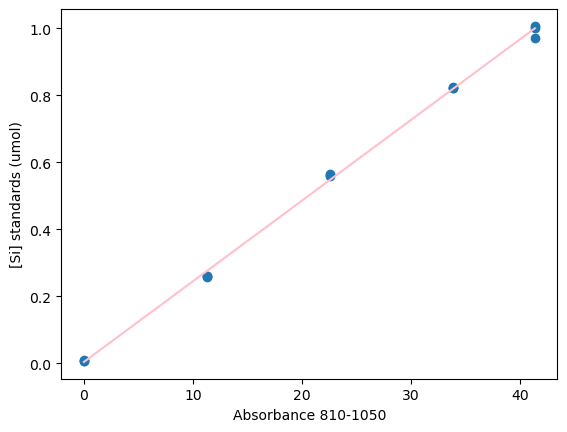

In [89]:
#plotting the Si calibration curve
plt.figure()
plt.scatter(Si_cali_concs, Si_cali_abs)
plt.plot(Si_cali_concs, Si_cali_curve.slope * Si_cali_concs + Si_cali_curve.intercept, color='Pink')
plt.ylabel('[Si] standards (umol)')
plt.xlabel('Absorbance 810-1050')

Text(0.5, 0, 'Absorbance 880-1050')

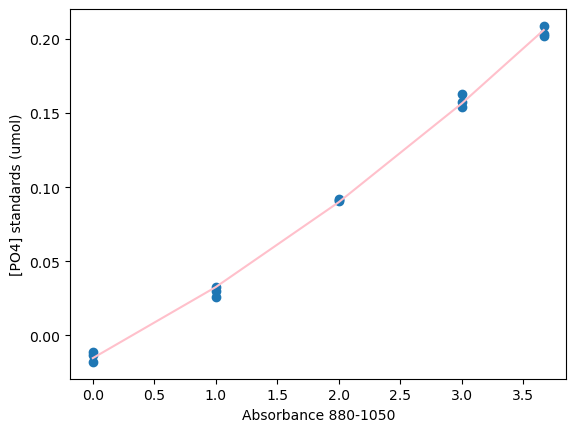

In [90]:
#plotting the PO4 calibration curve
plt.figure()
plt.scatter(PO4_cali_concs, PO4_cali_abs)
PO4_reg = a * PO4_cali_concs**2 + b * PO4_cali_concs + c
plt.plot(PO4_cali_concs, PO4_reg, color='pink')
plt.ylabel('[PO4] standards (umol)')
plt.xlabel('Absorbance 880-1050')

In [95]:
Si_samples = ["A2_Si", "A3_Si", "A4_Si", "B2_Si", "B3_Si", "B4_Si", "C2_Si", "C3_Si", "C4_Si", "D1_Si", "D2_Si"]

P_samples = ["A1_PO4", "A3_PO4", "A4_PO4", "B1_PO4", "B3_PO4", "B4_PO4", "C1_PO4", "C3_PO4", "C4_PO4", "D1_PO4", "D2_PO4"]


#Si
for sample in Si_samples:
    avg_abs = filtered_df.loc[filtered_df['Name'].str.contains(sample, case=False), 'AVE810_1050'].mean()
    Si_conc, Si_u_combined = cc.calc_Si_conc_and_uncert(
        avg_abs,
        Si_yint,
        Si_slope,
        Sxo_Si,
        Si_slope_err,
        Si_yint_err
    )
#PO4
for sample in P_samples:
    avg_abs = filtered_df.loc[filtered_df['Name'].str.contains(sample, case=False), 'AVE880_1050'].mean()
    PO4_conc, PO4_u_combined = cc.calc_PO4_conc_and_uncert(
        avg_abs,
        a,
        b,
        c,
        Sxo_PO4
    )
